# Preprocesamiento Imágenes

En esta sección se definen y aplican las transformaciones necesarias para preparar las imágenes antes de su uso para el entrenamiento del modelo.

Para esta primera fase se realizará un redimensionado a 224x224 píxeles y un recorte central (CenterCrop) para evitar deformaciones, siguiendo los requisitos de entrada de ResNet18. 

Además, se normalizarán los valores de los píxeles con las medias y desviaciones estándar de ImageNet, lo que permite aprovechar el entrenamiento previo (transfer learning) de la red.

In [2]:
# Instalación e importación de librerías
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

print("NumPy      :", np.__version__)
print("Pandas     :", pd.__version__)
print("PyTorch    :", torch.__version__)
import torchvision
print("TorchVision:", torchvision.__version__)


NumPy      : 2.2.6
Pandas     : 2.3.2
PyTorch    : 2.5.1
TorchVision: 0.20.1


In [3]:
# Carga del dataset
df = pd.read_csv("../Data/csv/full_df.csv")

# Ruta de las imágenes
image_dir = "../ODIR-5K/ODIR-5K/Training Images"

In [4]:
# Preprocesado inicial para ResNet18:
transform_img = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [6]:
def denormalize_imagenet(t):
    """ 
    Denormaliza una imagen de ImageNet.
    """
    # t: tensor CxHxW
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    t = t * std + mean
    t = t.clamp(0, 1)
    return t

In [7]:
# Muestra n imágenes original vs procesada para una columna (Left-Fundus o Right-Fundus)
def show_before_after_side(df, image_dir, transform, side_col="Left-Fundus", n=6):
    """
    Muestra n imágenes originales y transformadas de la columna indicada
    (Left-Fundus o Right-Fundus) para comparar antes y después del preprocesado.
    """
    sample = df.sample(n=min(n, len(df)), random_state=42)

    plt.figure(figsize=(8, 3 * len(sample)))
    for i, fname in enumerate(sample[side_col].astype(str)):
        path = os.path.join(image_dir, fname)

        with Image.open(path) as im:
            img = im.convert("RGB")
            img.thumbnail((768, 768))  # limita tamaño mostrado para ahorrar memoria

            img_t = transform(img) if transform is not None else img

            # Preparar imagen procesada para mostrar
            if isinstance(img_t, torch.Tensor):
                if (isinstance(transform, transforms.Compose) and 
                    any(isinstance(x, transforms.Normalize) for x in transform.transforms)):
                    img_t = denormalize_imagenet(img_t)
                img_show = img_t.permute(1, 2, 0).cpu().numpy()
            else:
                img_show = img_t

            # Original
            plt.subplot(len(sample), 2, 2*i + 1)
            plt.imshow(img)
            plt.title(f"{side_col} - Original")
            plt.axis("off")

            # Procesada
            plt.subplot(len(sample), 2, 2*i + 2)
            plt.imshow(img_show)
            plt.title("Procesada (224x224)")
            plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close('all')



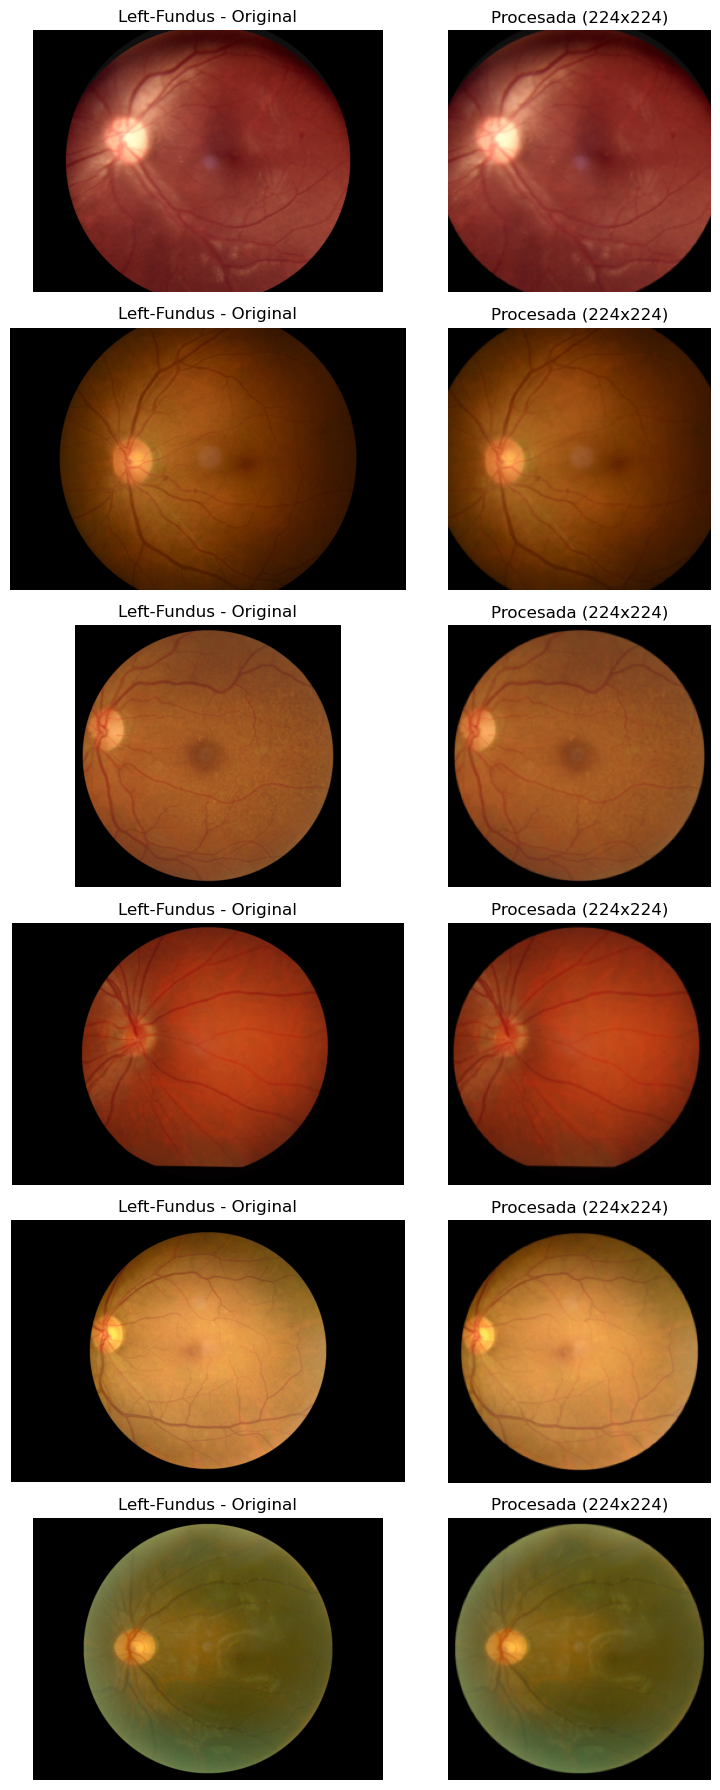

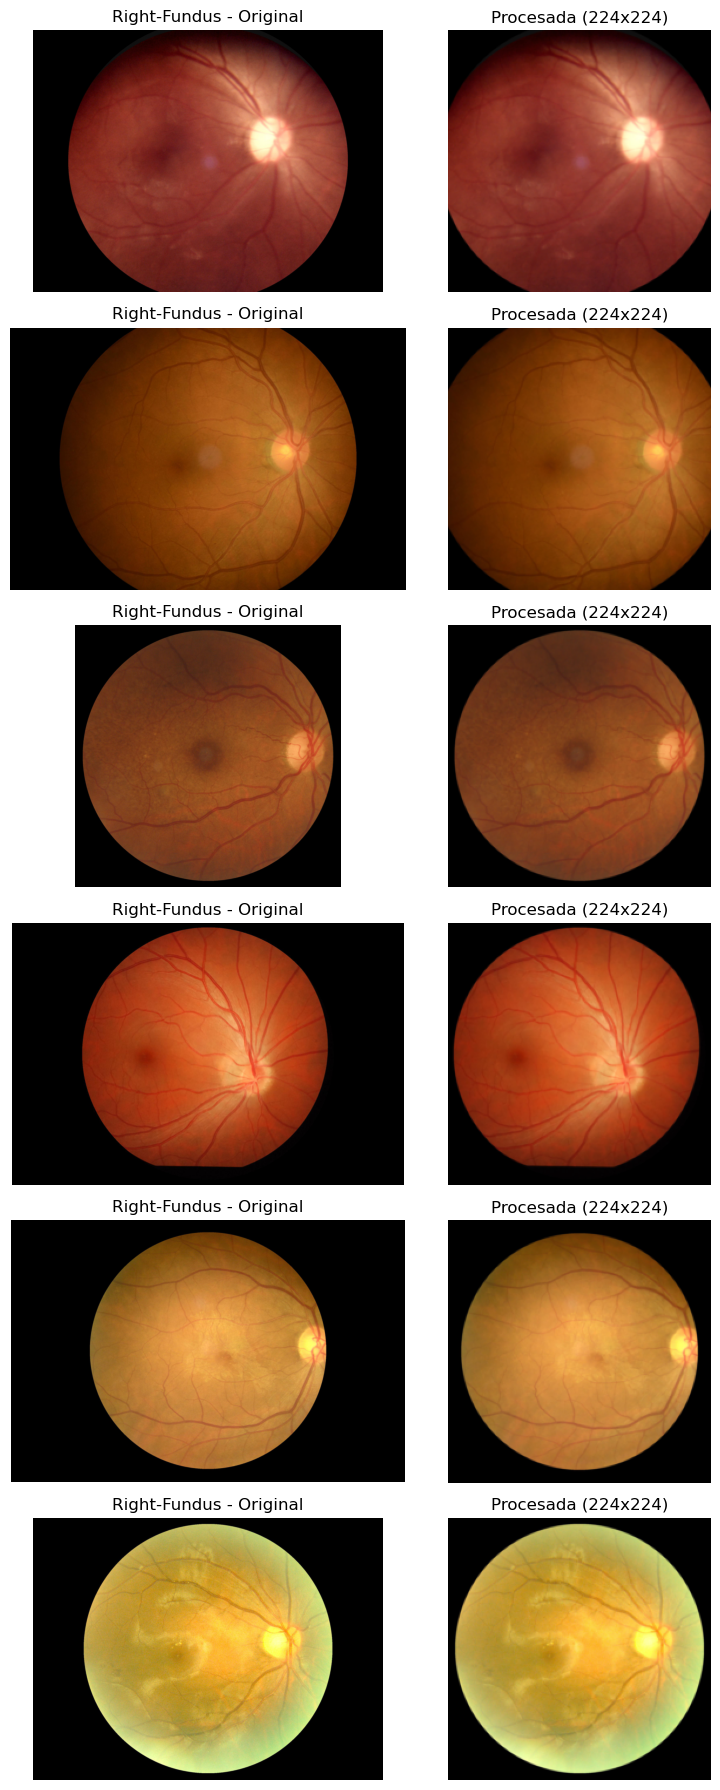

In [8]:
# Ejemplo: mostrar 6 imágenes del lado izquierdo
show_before_after_side(df, image_dir, transform_img, side_col="Left-Fundus", n=6)

# Ejemplo: mostrar 6 imágenes del lado derecho
show_before_after_side(df, image_dir, transform_img, side_col="Right-Fundus", n=6)